In [1]:
import sqlite3
import pandas as pd 
import numpy as np
import math
from numpy import arange
from matplotlib import cm
from scipy.interpolate import spline
import matplotlib.pyplot as plt
%matplotlib inline

### Define a function to run a query

In [2]:
def run_query(qry):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(qry, conn)

### Define a function to execute a command

In [3]:
def run_command(qry):
    with sqlite3.connect("chinook.db") as conn:
        conn.isolation_level = None
        conn.execute(qry)

### Define a function to show tables in the database

In [4]:
def show_tables(demand):
    df = run_query(demand)
    print(df)

### Define a query

In [5]:
querry = "SELECT name, type FROM sqlite_master WHERE type IN ('view', 'table');"
show_tables(querry)

               name   type
0             album  table
1            artist  table
2          customer  table
3          employee  table
4             genre  table
5           invoice  table
6      invoice_line  table
7        media_type  table
8          playlist  table
9    playlist_track  table
10            track  table
11           inv_dt   view
12    track_invoice   view
13  country_revised   view
14  tracks_invoiced   view


### Setting up a query to get total number of tracks sold per genre

In [6]:
each_genre = '''

SELECT 
    ge.name, 
    COUNT(*) num_of_tracks, 
    CAST(COUNT(*) AS Float)*100/(SELECT COUNT(*) FROM track) percentage 
FROM track tr 
INNER JOIN genre ge ON ge.genre_id == tr.genre_id 
GROUP BY 1 
ORDER BY 2 DESC;
'''
genre_df = run_query(each_genre)
genre_df

,name,num_of_tracks,percentage
0,Rock,1297,37.025407
1,Latin,579,16.528690
2,Metal,374,10.676563
3,Alternative & Punk,332,9.477591
4,Jazz,130,3.711105
5,TV Shows,93,2.654867
6,Blues,81,2.312304
7,Classical,74,2.112475
8,Drama,64,1.827005
9,R&B/Soul,61,1.741365


### Generate graph showing sale of each genre (absolute numbers)

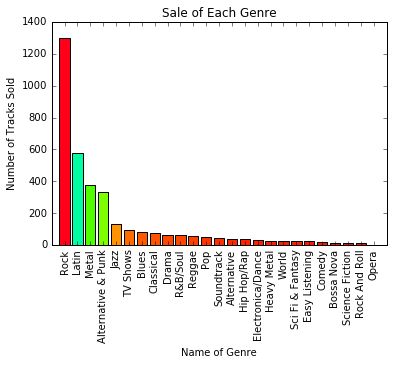

In [7]:
# Preparing bar chart values
bar_positions = range(25)
bar_heights = genre_df["num_of_tracks"]

# Develop color palette for bars
bar_colors = cm.hsv( bar_heights / float(max(bar_heights)))

# Develop color bar chart
plt.bar(bar_positions, bar_heights, align="center", color=bar_colors, tick_label=genre_df["name"])
plt.xticks(rotation=90)
plt.xlim(-1,25)
plt.ylim(0,1400)
plt.xlabel("Name of Genre")
plt.ylabel("Number of Tracks Sold")
plt.title("Sale of Each Genre")

### Generate graph showing proportion of each genre sold

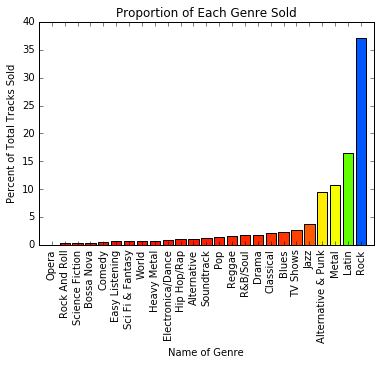

In [8]:
# Preparing bar chart values
bar_positions = range(25)
bar_heights = genre_df["percentage"].sort_values()

# Develop color palette for bars
bar_colors = cm.hsv(bar_heights / float(np.var(bar_heights)))
ticks = genre_df.sort_values(by='percentage', ascending=True)['name']

# Develop color bar chart
plt.bar(bar_positions, bar_heights, align="center", color=bar_colors, tick_label=ticks)
plt.xticks(rotation=90)
plt.xlim(-1,25)
plt.ylim(0,40)
plt.xlabel("Name of Genre")
plt.ylabel("Percent of Total Tracks Sold")
plt.title("Proportion of Each Genre Sold")

### Finding three most saleble artist for top 3 highest sold genre

In [9]:
artist_select = '''
SELECT 
    ge.name genre_name, 
    sq.art_name artist_name, 
    count(sq.track_il_id) tracks_sold_genre 

FROM genre ge 
INNER JOIN 
    (
    SELECT 
        tr.genre_id genre_id,
        ar.name art_name, 
        tr.name track_name,
        il.track_id track_il_id
    FROM track tr 
    INNER JOIN album ab ON ab.album_id = tr.album_id 
    INNER JOIN artist ar ON ab.artist_id = ar.artist_id
    INNER JOIN invoice_line il ON il.track_id = tr.track_id
    ) sq 
ON ge.genre_id = sq.genre_id 
WHERE genre_name IN ('Rock', 'Latin', 'Metal') 
GROUP BY 1 
ORDER BY 3 DESC 
LIMIT 3;
'''

artist_df = run_query(artist_select)
artist_df

,genre_name,artist_name,tracks_sold_genre
0,Rock,The Posies,2635
1,Metal,Lenny Kravitz,619
2,Latin,Luciana Souza/Romero Lubambo,167


### Purchase recommendation for the three most saleble artists

### Finding three most saleble artist based on individual sale volume

In [10]:
top_tracks = '''
SELECT 
    cmb.track_name track_name,
    ar.name artist_name, 
    cmb.ge_names genre_name, 
    count(cmb.il_trackid) num_indi_tracks_sold 
FROM artist ar 
INNER JOIN 
    (
    SELECT 
        ab.artist_id artistID, 
        tr.name track_name, 
        ge.name ge_names,
        il.track_id il_trackid
    FROM track tr 
    INNER JOIN genre ge ON tr.genre_id = ge.genre_id 
    INNER JOIN album ab ON ab.album_id = tr.album_id
    INNER JOIN invoice_line il ON tr.track_id = il.track_id
    ) cmb 
ON ar.artist_id = cmb.artistID 
GROUP BY 1
ORDER BY 4 DESC 
LIMIT 3;
'''
artist_list = run_query(top_tracks)
artist_list

,track_name,artist_name,genre_name,num_indi_tracks_sold
0,War Pigs,Cake,Alternative,33
1,Are You Experienced?,Jimi Hendrix,Rock,14
2,Changes,Godsmack,Metal,14


Based on the individual sale volumn of songs, we can reccomend purchase of albums for the following top three artists:

(1) Cake
(2) Jimi Hendrix
(3) Goldsmack

### Getting sales data for all employees

In [11]:
print("List of Staff Members with Title: \n")
employee_names = '''
SELECT 
    em.first_name || ' ' || em.last_name name, 
    em.title, em.hire_date 
    FROM employee em;
'''
emp_nm = run_query(employee_names)
print(emp_nm)

print("\n Total Sale by Individual Sales Personnel: \n")
employee_sale = '''
SELECT 
    em.first_name || ' ' || em.last_name employee_name, 
    em.title designation, 
    (SELECT julianday('now') - julianday(em.hire_date))/(30) seniority_in_mo, 
    SUM(sq.totsale) total_sale 
FROM employee em 
INNER JOIN 
    (
    SELECT 
        cu.support_rep_id, iv.total totsale 
    FROM customer cu 
    INNER JOIN invoice iv ON iv.customer_id == cu.customer_id) sq 
ON em.employee_id  == sq.support_rep_id 
GROUP BY 1 ORDER BY 4 DESC;
'''
employee_df = run_query(employee_sale)
employee_df

List of Staff Members with Title: 

               name                title            hire_date
0      Andrew Adams      General Manager  2016-08-14 00:00:00
1     Nancy Edwards        Sales Manager  2016-05-01 00:00:00
2      Jane Peacock  Sales Support Agent  2017-04-01 00:00:00
3     Margaret Park  Sales Support Agent  2017-05-03 00:00:00
4     Steve Johnson  Sales Support Agent  2017-10-17 00:00:00
5  Michael Mitchell           IT Manager  2016-10-17 00:00:00
6       Robert King             IT Staff  2017-01-02 00:00:00
7    Laura Callahan             IT Staff  2017-03-04 00:00:00

 Total Sale by Individual Sales Personnel: 



,employee_name,designation,seniority_in_mo,total_sale
0,Jane Peacock,Sales Support Agent,16.846518,1731.51
1,Margaret Park,Sales Support Agent,15.779851,1584.00
2,Steve Johnson,Sales Support Agent,10.213184,1393.92


### Plot for employee sales data

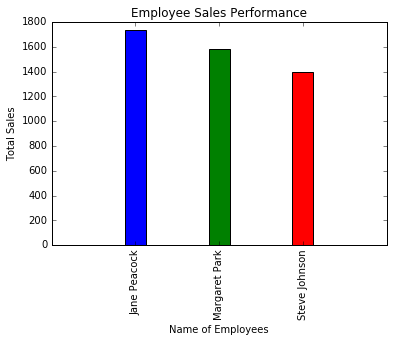

In [12]:
# Define Bar Chart Values
bar_positions = range(3)
bar_heights = employee_df["total_sale"]

# Develop Different Colors for bars
employees = employee_df["employee_name"]
color_palette = ['b', 'g', 'r']
color_dict = dict(zip(employees, color_palette))
bar_colors = employees.map(color_dict)

# Develop color bar chart
plt.bar(bar_positions, bar_heights, 0.25, align="center", color=bar_colors, tick_label=employee_df["employee_name"])
plt.xticks(rotation=90)
plt.xlim(-1,3)
plt.xlabel("Name of Employees")
plt.ylabel("Total Sales")
plt.title("Employee Sales Performance")

### Identify relationship between employee sales volume & seniority

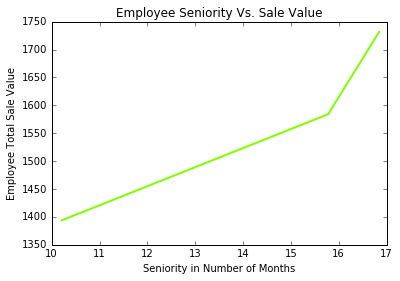

In [13]:
# Plot a scatter diagram to verify the correlation

x_data = employee_df['seniority_in_mo']
y_data = employee_df['total_sale']

plt.plot(x_data, y_data, c='chartreuse', linewidth=2)
plt.xlabel("Seniority in Number of Months")
plt.ylabel("Employee Total Sale Value")
plt.title("Employee Seniority Vs. Sale Value")
plt.show()

### Collect purchase data and scrutinize countries with less customers

In [14]:
# Removing views created from the previous run to avoid execution error
q1 = "DROP VIEW IF EXISTS country_revised"
run_command(q1)
# Creating view again to use it in the current execution
cmnd = '''
CREATE VIEW country_revised AS
    SELECT
        cu.customer_id cuid,
        cu.country cntr,
        COUNT(DISTINCT cu.customer_id) cust_count,
        SUM(iv.total) tot_sale,
        COUNT(iv.invoice_id) num_ord
    FROM customer cu
    INNER JOIN invoice iv ON cu.customer_id == iv.customer_id
    GROUP BY cntr;
'''
run_command(cmnd)

qry = '''

SELECT
    cntr country_org,
    country_revised,
    sort_ord sort_order,
    cust_count tot_cust,
    num_ord total_orders,
    tot_sale tot_sale_val,
    CAST(tot_sale AS Float)/CAST(cust_count AS Float) avg_sale_per_cust,
    CAST(tot_sale AS Float)/CAST(num_ord AS Float) avg_ord_val,
    CAST(num_ord AS Float)/CAST(cust_count AS Float) order_per_cust
FROM 
    (
    SELECT
        cr.*, 
        
        CASE 
            WHEN cr.cust_count == 1 THEN 'Other'
            ELSE cr.cntr
        END AS country_revised,
        
        CASE 
            WHEN cr.cust_count == 1 THEN 1
            ELSE 0 
        END AS sort_ord
    
    FROM country_revised cr
    )
GROUP BY cuid
ORDER BY sort_ord ASC, tot_sale DESC;
'''

purchase_per_country = run_query(qry)
purchase_per_country

,country_org,country_revised,sort_order,tot_cust,total_orders,tot_sale_val,avg_sale_per_cust,avg_ord_val,order_per_cust
0,USA,USA,0,13,131,1040.49,80.037692,7.942672,10.076923
1,Canada,Canada,0,8,76,535.59,66.948750,7.047237,9.500000
2,Brazil,Brazil,0,5,61,427.68,85.536000,7.011148,12.200000
3,France,France,0,5,50,389.07,77.814000,7.781400,10.000000
4,Germany,Germany,0,4,41,334.62,83.655000,8.161463,10.250000
5,Czech Republic,Czech Republic,0,2,30,273.24,136.620000,9.108000,15.000000
6,United Kingdom,United Kingdom,0,3,28,245.52,81.840000,8.768571,9.333333
7,Portugal,Portugal,0,2,29,185.13,92.565000,6.383793,14.500000
8,India,India,0,2,21,183.15,91.575000,8.721429,10.500000
9,Ireland,Other,1,1,13,114.84,114.840000,8.833846,13.000000


## Evaluate Strategy for Underdeveloped Markets

### Verify Marketing Needs based on the Average Customer Sale Value

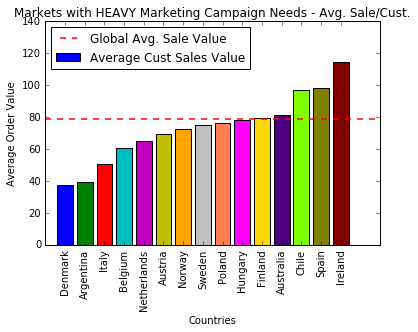

In [15]:
# List the countries with low sale  volume
low_sale_market = purchase_per_country[purchase_per_country['sort_order'] == 1]

# Get global average customer sales value
global_avg_cust_sale = purchase_per_country['avg_sale_per_cust'].mean()

# Definie the color settings for countries with underdeveloped market
country_ord_avgcs = low_sale_market.sort_values(by='avg_sale_per_cust')['country_org']
unique_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'silver', 'coral', 'fuchsia', 'gold', 'indigo', 'chartreuse', 'olive', 'maroon']
color_deck = dict(zip(country_ord_avgcs, unique_colors))
apply_colors = country_ord_avgcs.map(color_deck)

# Develop Country Specific Color Plot
bar_positions = range(15)
bar_heights = low_sale_market["avg_sale_per_cust"].sort_values()

plt.bar(bar_positions, bar_heights, align="center", color=apply_colors, tick_label=country_ord_avgcs, label="Average Cust Sales Value")
plt.xticks(rotation=90)
plt.xlim(-1,16)
plt.ylim(0,140)
plt.axhline(global_avg_cust_sale, color='r', linestyle='--', linewidth=1.5, label="Global Avg. Sale Value")
plt.legend(loc='upper left')
plt.xlabel("Countries")
plt.ylabel("Average Order Value")
plt.title("Markets with HEAVY Marketing Campaign Needs - Avg. Sale/Cust.")

### Verify Marketing Needs based on the Average Order Value

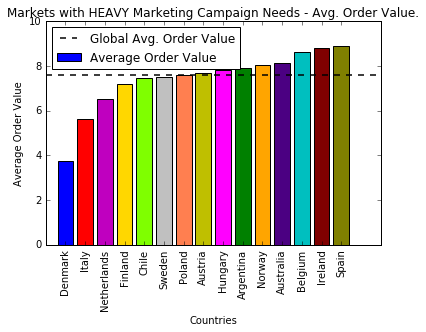

In [16]:
# Get global average customer sales value
global_avg_ord_val = purchase_per_country['avg_ord_val'].mean()

# Definie the color settings for countries with underdeveloped market
country_avg_ordval = low_sale_market.sort_values(by='avg_ord_val')['country_org']
apply_colors = country_avg_ordval.map(color_deck)

# Develop Country Specific Color Plot
bar_positions = range(15)
bar_heights = low_sale_market['avg_ord_val'].sort_values()

plt.bar(bar_positions, bar_heights, align="center", color=apply_colors, tick_label=country_avg_ordval, label="Average Order Value")
plt.xticks(rotation=90)
plt.xlim(-1,16)
plt.ylim(0,10)
plt.axhline(global_avg_ord_val, color='k', linestyle='--', linewidth=1.5, label="Global Avg. Order Value")
plt.legend(loc='upper left')
plt.xlabel("Countries")
plt.ylabel("Average Order Value")
plt.title("Markets with HEAVY Marketing Campaign Needs - Avg. Order Value.")

## Evaluate Strategy for Developed Markets

### Verify Marketing Needs based on the Total Order Volume

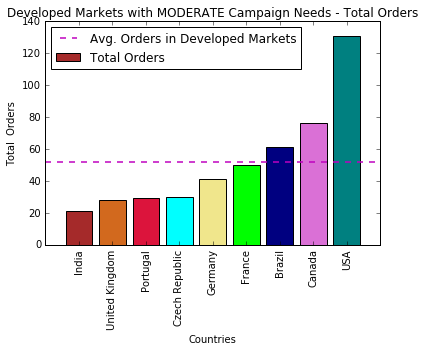

In [17]:
# Seggregate the countries with better sale  volume
developed_mkt_sale = purchase_per_country[purchase_per_country['sort_order'] == 0]

# Get average customer sales value for the developed market
dev_avg_orders = developed_mkt_sale['total_orders'].mean()

# Definie the color settings for the countries with developed market
country_tot_ord_dev = developed_mkt_sale.sort_values(by='total_orders')['country_org']
unique_colors = ['brown', 'chocolate', 'crimson', 'cyan', 'khaki', 'lime', 'navy', 'orchid', 'teal']
color_deck_dev = dict(zip(country_tot_ord_dev, unique_colors))
applied_colors = country_tot_ord_dev.map(color_deck_dev)

# Develop Country Specific Color Plot
bar_positions = range(9)
bar_heights = developed_mkt_sale["total_orders"].sort_values()

plt.bar(bar_positions, bar_heights, align="center", color=applied_colors, tick_label=country_tot_ord_dev, label="Total Orders")
plt.xticks(rotation=90)
plt.xlim(-1,9)
plt.ylim(0,140)
plt.axhline(dev_avg_orders, color='m', linestyle='--', linewidth=1.5, label="Avg. Orders in Developed Markets")
plt.legend(loc='upper left')
plt.xlabel("Countries")
plt.ylabel("Total  Orders")
plt.title("Developed Markets with MODERATE Campaign Needs - Total Orders")

## Get Global Market Status

### For Countries With Underdeveloped Maket

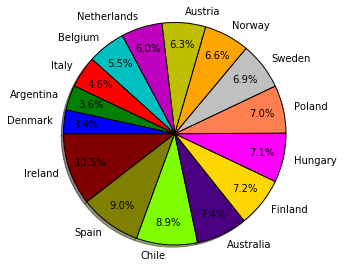


Average Sales Share in the Underdeveloped Market = 6.67%


In [18]:
# Get total sales share
low_mkt_share = low_sale_market['tot_sale_val']
apply_colors = list(low_sale_market['country_org'].map(color_deck))

# Develop Country Specific Color Pie Chart
plt.pie(low_mkt_share, labels=low_sale_market['country_org'], colors=apply_colors, startangle=180, shadow=True, autopct='%1.1f%%', pctdistance=0.80)
plt.axis('equal')
plt.show()

# Get average sale share of the unerdeveloped market
print("\nAverage Sales Share in the Underdeveloped Market = {0:.2f}%".format(low_mkt_share.mean()*100/low_mkt_share.sum()))

### For Countries with Developed Maket

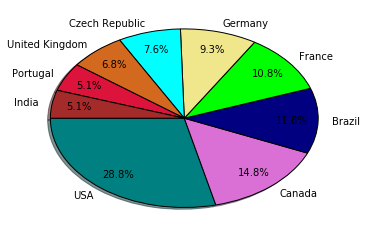


Average Sales Share in the Developed Market = 11.11%


In [19]:
# Get total sales share
high_mkt_share = developed_mkt_sale['tot_sale_val']
applid_colors = list(developed_mkt_sale['country_org'].map(color_deck_dev))

# Develop Country Specific Color Pie Chart
plt.pie(high_mkt_share, labels=developed_mkt_sale['country_org'], colors=applied_colors, startangle=180, shadow=True, autopct='%1.1f%%', pctdistance=0.80)
plt.show()

# Get average sale share of the unerdeveloped market
print("\nAverage Sales Share in the Developed Market = {0:.2f}%".format(high_mkt_share.mean()*100/high_mkt_share.sum()))

### Verify Purchases With Full Albums vs. Popular Tracks

In [20]:
# Develope a query

complete_album_purchase = '''
WITH inv_track_check AS 
    (
    SELECT
        il.invoice_id invoice_num,
        MIN(il.track_id) first_track,
        tr.album_id album_id
    FROM invoice_line il 
    INNER JOIN track tr
    ON il.track_id = tr.track_id
    GROUP BY 1
    )
    
SELECT
    album_selection,
    COUNT(invoice_num) num_of_invoices,
    ROUND(CAST(COUNT(invoice_num) AS FLOAT) * 100 / (SELECT COUNT(*) FROM inv_track_check), 2) percentage

FROM
        (
        SELECT
            itc.*,
            CASE
                WHEN
                    (
                    SELECT
                        tr1.track_id FROM track tr1
                        WHERE tr1.album_id = itc.album_id
                        
                        EXCEPT
                        
                    SELECT
                        il1.track_id FROM invoice_line il1
                        WHERE il1.invoice_id = itc.invoice_num
                        ) IS NULL THEN "Yes"
                    ELSE "No"
            END AS "album_selection"
        FROM inv_track_check itc
        )
GROUP BY 1;
'''

run_query(complete_album_purchase)

,album_selection,num_of_invoices,percentage
0,No,497,80.94
1,Yes,117,19.06


### Identify Artist Who is Used in the Most Playlists

In [21]:
# Develope a query

most_used_artist = '''

WITH playlist_track_album AS 
(
    SELECT
        plt.playlist_id playlist_id,
        tr.track_id track_id,
        ab.album_id album_id,
        ab.artist_id artist_id
    FROM playlist_track plt
    INNER JOIN track tr ON plt.track_id = tr.track_id
    INNER JOIN album ab ON ab.album_id = tr.album_id
    GROUP BY 1, 4
)

SELECT
    art.name artist_name,
    COUNT(ply.name) artist_frequency
    
FROM
     playlist_track_album pta
     INNER JOIN playlist ply ON ply.playlist_id = pta.playlist_id
     INNER JOIN artist art ON art.artist_id = pta.artist_id 
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5;
'''

run_query(most_used_artist)

,artist_name,artist_frequency
0,Eugene Ormandy,7
1,Academy of St. Martin in the Fields & Sir Nevi...,6
2,Berliner Philharmoniker & Herbert Von Karajan,6
3,English Concert & Trevor Pinnock,6
4,The King's Singers,6


### Determine Tracks Purchase History 

In [22]:
q2 = "DROP VIEW IF EXISTS tracks_invoiced"
run_command(q2)

create_table = '''
CREATE VIEW tracks_invoiced AS
    SELECT 
        tr.track_id track_total,
        il.track_id track_sold,
        il.invoice_id invoice_id
    FROM track tr
    LEFT OUTER JOIN invoice_line il
    ON tr.track_id = il.track_id
    GROUP BY 1;
'''

run_command(create_table)


tracks_purchased = '''
SELECT
    COUNT(ti.track_sold) num_tracks_sold,
    (SELECT COUNT(track_total) FROM tracks_invoiced) - (SELECT COUNT(track_sold) FROM tracks_invoiced) num_tracks_unsold,
    COUNT(ti.track_total) total_tracks,
    ROUND(CAST((SELECT COUNT(track_sold) FROM tracks_invoiced) AS FLOAT) * 100 / (SELECT COUNT(*) FROM tracks_invoiced), 2) percent_sold,
    ROUND(CAST(((SELECT COUNT(track_total) FROM tracks_invoiced) - (SELECT COUNT(track_sold) FROM tracks_invoiced)) AS FLOAT) * 100 / (SELECT COUNT(*) FROM tracks_invoiced), 2) percent_unsold
    
FROM
    tracks_invoiced ti;
'''

run_query(tracks_purchased)

,num_tracks_sold,num_tracks_unsold,total_tracks,percent_sold,percent_unsold
0,1806,1697,3503,51.56,48.44


### Identify Popular Top 2% Saleable Tracks 

In [23]:
# Find top 2% of the most saleble tracks in the store

most_saleable_tracks = '''
WITH track_invline AS
    (
    SELECT
        tr.name track_name,
        ab.title album_name,
        COUNT(il.track_id) num_sold

    FROM track tr
    INNER JOIN invoice_line il ON il.track_id = tr.track_id
    INNER JOIN album ab ON tr.album_id = ab.album_id
    GROUP BY 1
    )
    
SELECT * FROM track_invline
ORDER BY num_sold DESC
LIMIT (SELECT CAST(ROUND(COUNT(*) * 2 / 100) AS INTEGER)
       FROM track_invline);
'''
    
run_query(most_saleable_tracks)

,track_name,album_name,num_sold
0,War Pigs,Cake: B-Sides and Rarities,33
1,Are You Experienced?,Are You Experienced?,14
2,Changes,Faceless,14
3,Highway Chile,Are You Experienced?,14
4,Hey Joe,Are You Experienced?,13
5,Put The Finger On You,For Those About To Rock We Salute You,13
6,Third Stone From The Sun,Are You Experienced?,13
7,Drain You,Nevermind,12
8,Love Or Confusion,Are You Experienced?,12
9,Radio/Video,Mezmerize,12


### Effect of Protected vs. Non-Protected Media on Popularity

,media_type,num_sold,percent,legend
0,MPEG audio file,4259,89.5312,0
1,Protected AAC audio file,439,9.22851,1
2,Purchased AAC audio file,35,0.735758,2
3,AAC audio file,21,0.441455,3
4,Protected MPEG-4 video file,3,0.063065,4


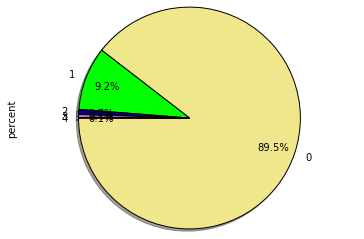

In [24]:
# Identify media type mix in the top 2% most saleble tracks in the store

media_type_impact = '''
WITH track_inv_media AS
    (
    SELECT
        mt.name media_type,
        COUNT(il.track_id) num_sold,
        CAST(COUNT(il.track_id) AS FLOAT) * 100 / (SELECT COUNT(*) FROM invoice_line) percent

    FROM track tr
    INNER JOIN invoice_line il ON il.track_id = tr.track_id
    INNER JOIN media_type mt ON tr.media_type_id = mt.media_type_id
    GROUP BY 1
    )
    
SELECT * FROM track_inv_media
ORDER BY num_sold DESC
LIMIT 10;
'''

media_impact = run_query(media_type_impact)

# Develop tabular result

def color_val(num):
    color_val = color_spec[num]
    return 'background-color: %s' % color_val

def color_font(num):
    color_val = color_spec[num]
    return 'color: %s' % color_val

## Introducing color spectrum and legend in the dataframe
color_spec = ['khaki', 'lime', 'navy', 'orchid', 'teal']
header_list = ['media_type', 'num_sold', 'percent', 'legend']
media_impact = media_impact.reindex(columns=header_list)
media_impact['legend'] = [i for i in range(5)]

# Develop Pie Chart
media_impact['percent'].plot.pie(colors=color_spec, startangle=180, shadow=True, 
        autopct='%1.1f%%', pctdistance=0.8)
plt.axis('equal')

# Print the combined results
media_impact.style.applymap(color_font, subset=['legend']).applymap(color_val, subset=['legend'])